# Randomized Benchmarking


## Introduction

**Randomization benchmarking (RB)** is a well-known technique to measure average gate performance by running sequences of random Clifford gates that should return the qubits to the initial state. 
Qiskit Ignis has tools to generate one- and two-qubit Clifford gate sequences simultaneously. 

This notebook gives an example for how to use the ``ignis.verification.randomized_benchmarking`` module. This particular example shows how to run 2-qubit randomized benchmarking (RB) simultaneous with 1-qubit RB. There are also examples on how to use some of the companion functions for predicting RB fidelity.


In [1]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import Qiskit classes
import qiskit
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import (depolarizing_error,
                                                               thermal_relaxation_error,
                                                               coherent_unitary_error)

from qiskit.quantum_info import SuperOp
from qiskit import QuantumCircuit

#Import the RB Functions
from qiskit.ignis.verification.randomized_benchmarking.experiments import (RBGenerator,
                                                                           RBAnalysis,
                                                                           RBExperiment,
                                                                           InterleavedRBExperiment,
                                                                           PurityRBExperiment,
                                                                           RBUtils)

## 1) Select the Parameters of the RB Run <a name='select_params_RB'></a>

First, wee need to choose the following parameters:

- **nseeds:** The number of seeds. For each seed you will get a separate list of output circuits in rb_circs.
- **length_vector:** The length vector of Clifford lengths. Must be in ascending order. RB sequences of increasing length grow on top of the previous sequences.
- **rb_pattern:** A list of the form [[i,j],[k],...] which will make simultaneous RB sequences where Qi,Qj are a 2-qubit RB sequence and Qk is a 1-qubit sequence, etc. The number of qubits is the sum of the entries. For 'regular' RB the qubit_pattern is just [[0]],[[0,1]].
- **length_multiplier:** If this is an array it scales each rb_sequence by the multiplier.
- **seed_offset:** What to start the seeds at (e.g. if we want to add more seeds later).
- **align_cliffs:**  If true adds a barrier across all qubits in rb_pattern after each set of cliffords.

In this example we have 3 qubits Q0,Q1,Q2. 
We are running 2Q RB (on qubits Q0,Q2) and 1Q RB (on qubit Q1) simultaneously, 
where there are twice as many 1Q Clifford gates.

In [2]:
#Number of qubits
nQ = 3
#There are 3 qubits: Q0,Q1,Q2.
#Number of seeds (random sequences)
nseeds = 5
#Number of Cliffords in the sequence (start, stop, steps)
nCliffs = np.arange(1,200,20)

## 2) Create the RB experiments <a name='gen_RB_seq'></a>

We generate RB experiments. We start with a small example (so it doesn't take too long to run). This is done by using the `RBExperiment` class.

In [3]:
exp02 = RBExperiment(nseeds=1, qubits=[0,2], lengths=nCliffs)
exp1 = RBExperiment(nseeds=1, qubits=[1], lengths=[x*3 for x in nCliffs])

As an example, we print the circuit corresponding to the first RB sequence of the 2-qubit experiment:

In [4]:
print(exp02.generator.circuits()[0])

      ┌───┐┌───┐           ░ ┌─────┐┌───┐       ┌─┐        
qr_0: ┤ H ├┤ S ├───────────░─┤ SDG ├┤ H ├───────┤M├────────
      └───┘└───┘           ░ └─────┘└───┘       └╥┘        
qr_1: ───────────────────────────────────────────╫─────────
      ┌───┐┌───┐┌───┐┌───┐ ░ ┌─────┐┌───┐┌─────┐ ║ ┌───┐┌─┐
qr_2: ┤ X ├┤ S ├┤ H ├┤ S ├─░─┤ SDG ├┤ H ├┤ SDG ├─╫─┤ X ├┤M├
      └───┘└───┘└───┘└───┘ ░ └─────┘└───┘└─────┘ ║ └───┘└╥┘
cr: 2/═══════════════════════════════════════════╩═══════╩═
                                                 0       1 


## Look at the Unitary for 1 Circuit

The Unitary representing each RB circuit should be the identity (with a global phase),
since we multiply random Clifford elements, including a computed reversal gate. We simulate this using an Aer unitary simulator.

In [5]:
#Create a new circuit without the measurement
circ = exp02.generator.circuits()[-1]
qc = qiskit.QuantumCircuit(*circ.qregs,*circ.cregs)
for i in circ[0:-2]:
    qc.data.append(i)
backend = qiskit.Aer.get_backend('unitary_simulator')
basis_gates = ['u1', 'u2', 'u3', 'cx'] # use U,CX for now
job = qiskit.execute(qc, backend=backend, basis_gates=basis_gates)
print(np.around(job.result().get_unitary(), 3))

[[ 0.707+0.707j -0.   +0.j     0.   +0.j     0.   +0.j     0.   -0.j
   0.   +0.j     0.   +0.j     0.   +0.j   ]
 [-0.   +0.j     0.707+0.707j  0.   +0.j     0.   +0.j    -0.   +0.j
   0.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.707+0.707j -0.   +0.j     0.   +0.j
   0.   +0.j     0.   -0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j    -0.   +0.j     0.707+0.707j  0.   +0.j
   0.   +0.j    -0.   +0.j     0.   +0.j   ]
 [ 0.   -0.j    -0.   +0.j     0.   +0.j     0.   +0.j     0.707+0.707j
  -0.   -0.j     0.   +0.j     0.   +0.j   ]
 [-0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   -0.j
   0.707+0.707j  0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   -0.j    -0.   +0.j     0.   +0.j
   0.   +0.j     0.707+0.707j -0.   -0.j   ]
 [ 0.   +0.j     0.   +0.j    -0.   +0.j     0.   +0.j     0.   +0.j
   0.   +0.j     0.   -0.j     0.707+0.707j]]


## Define the noise model

We define a noise model for the simulator. To simulate decay, we add depolarizing error probabilities to the CNOT and U gates.

In [6]:
noise_model = NoiseModel()
p1Q = 0.002
p2Q = 0.01
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

## 3) Run the RB experiment on Aer simulator <a name='ex_RB_seq'></a>

We can run the RB experiment either using a Qiskit Aer Simulator (with some noise model) or using an IBMQ provider. The results are automatically passed to the fitter.

In [7]:
backend = qiskit.Aer.get_backend('qasm_simulator')
shots = 200

rb_result_02 = exp02.run(backend, noise_model=noise_model, shots=shots)
rb_result_1 = exp1.run(backend, noise_model=noise_model, shots=shots)
results = [rb_result_02, rb_result_1]

## 4) Fit the RB results and calculate the gate fidelity <a name='fit_RB'></a>

### Get statistics about the survival probabilities

The results in **result_list** should fit to an exponentially decaying function $A \cdot \alpha ^ m + B$, where $m$ is the Clifford length.

From $\alpha$ we can calculate the **Error per Clifford (EPC)**:
$$ EPC = \frac{2^n-1}{2^n} (1-\alpha)$$
(where $n=nQ$ is the number of qubits).

### Plot After 1 Seed

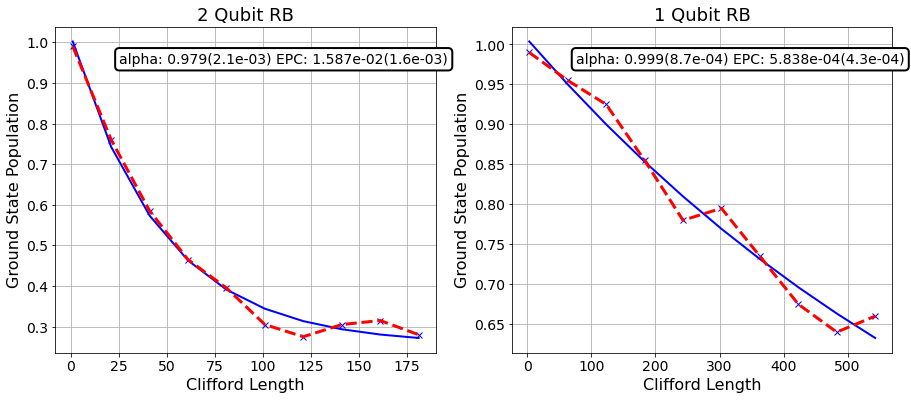

In [8]:
plt.figure(figsize=(15, 6))

for i in range(2):
    ax = plt.subplot(1, 2, i+1)

    # Plot the essence by calling RBResult.plot
    results[i].plot(ax=ax, add_label=True, show_plt=False)

    # Add title and label
    ax.set_title('%d Qubit RB'%(results[i].num_qubits()), fontsize=18)

plt.show()

### Plot with the Rest of the Seeds 
The plot is being updated after each seed.

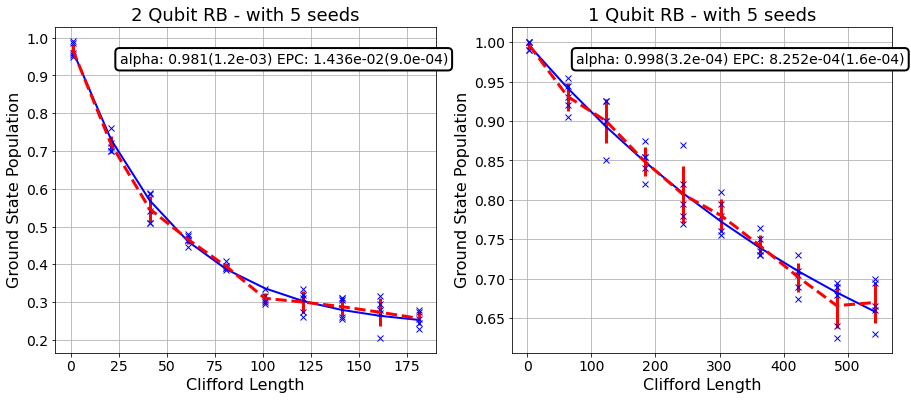

In [9]:
import time
for seed_num in range(1, nseeds):
    plt.figure(figsize=(15, 6))
    axis = [plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)]
    
    # Add another seed to the data
    rb_result_02 = exp02.run_additional_seeds(1)
    rb_result_1 = exp1.run_additional_seeds(1)
    results = [rb_result_02, rb_result_1]
    
    for i in range(2):
        # Plot the essence by calling RBResult.plot
        results[i].plot(ax=axis[i], add_label=True, show_plt=False)

        # Add title and label
        axis[i].set_title('%d Qubit RB - with %d seeds'%(results[i].num_qubits(), seed_num + 1), fontsize=18)
        
    # Display
    display.display(plt.gcf())
    
    # Clear display after each seed and close
    display.clear_output(wait=True)
    time.sleep(1.0)
    plt.close()

### Add more shots to the data

In [10]:
shots = 200
rb_result_02 = exp02.run_additional_shots(shots)
rb_result_1 = exp1.run_additional_shots(shots)
results = [rb_result_02, rb_result_1]

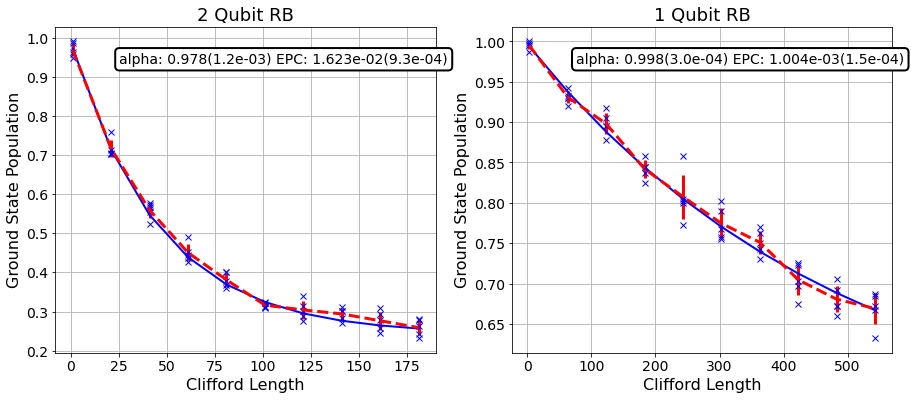

In [11]:
plt.figure(figsize=(15, 6))

for i in range(2):
    ax = plt.subplot(1, 2, i+1)

    # Plot the essence by calling RBResult.plot
    results[i].plot(ax=ax, add_label=True, show_plt=False)

    # Add title and label
    ax.set_title('%d Qubit RB'%(results[i].num_qubits()), fontsize=18)

plt.show()

### Predicted Gate Fidelity

From the known depolarizing errors on the simulation we can predict the **fidelity**. 
First we need to count the number of **gates per Clifford**.

The function **gates_per_clifford** takes a list of transpiled RB circuits and outputs the number of basis gates in each circuit.

In [12]:
#Count the number of single and 2Q gates in the 2Q Cliffords
gates_per_cliff = exp02.gates_per_clifford()
for basis_gate in basis_gates:
    print("Number of %s gates per Clifford: %f "%(basis_gate ,
                                                  np.mean([gates_per_cliff[0][basis_gate],
                                                           gates_per_cliff[2][basis_gate]])))

Number of u1 gates per Clifford: 0.119239 
Number of u2 gates per Clifford: 1.680761 
Number of u3 gates per Clifford: 0.174891 
Number of cx gates per Clifford: 1.517826 


The function **calculate_2q_epc** gives measured errors in the basis gates that were used to construct the Clifford. 
It assumes that the error in the underlying gates is depolarizing. It outputs the error per a 2-qubit Clifford.

The input to this function is:
- **gate_per_cliff:** dictionary of gate per Clifford. 
- **epg_2q:** EPG estimated by error model.
- **qubit_pair:** index of two qubits to calculate EPC. 
- **list_epgs_1q:** list of single qubit EPGs of qubit listed in ``qubit_pair``.
- **two_qubit_name:** name of two qubit gate in ``basis gates`` (default is ``cx``).

In [13]:
# Error per gate from noise model
epgs_1q = {'u1': 0, 'u2': p1Q/2, 'u3': 2*p1Q/2}
epg_2q = p2Q*3/4
pred_epc = RBUtils.calculate_2q_epc(
    gate_per_cliff=gates_per_cliff,
    epg_2q=epg_2q,
    qubit_pair=[0, 2],
    list_epgs_1q=[epgs_1q, epgs_1q])

# Calculate the predicted epc
print("Predicted 2Q Error per Clifford: %e"%pred_epc)

Predicted 2Q Error per Clifford: 1.614229e-02


## Run an RB Sequence with T1,T2 Errors

We now choose RB sequences that contain only 2-qubit Cliffords.

We execute these sequences as before, but with a noise model extended with T1/T2 thermal relaxation error, and fit the exponentially decaying curve. 

In [14]:
noise_model2 = NoiseModel()

#Add T1/T2 noise to the simulation
t1 = 100.
t2 = 80.
gate1Q = 0.1
gate2Q = 0.5
noise_model2.add_all_qubit_quantum_error(thermal_relaxation_error(t1,t2,gate1Q), 'u2')
noise_model2.add_all_qubit_quantum_error(thermal_relaxation_error(t1,t2,2*gate1Q), 'u3')
noise_model2.add_all_qubit_quantum_error(
    thermal_relaxation_error(t1,t2,gate2Q).tensor(thermal_relaxation_error(t1,t2,gate2Q)), 'cx')

In [15]:
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 500

exp01 = RBExperiment(nseeds=1, qubits=[0,1], lengths=nCliffs)
rb_result_01 = exp01.run(backend, noise_model=noise_model, shots=shots, basis_gates=basis_gates)

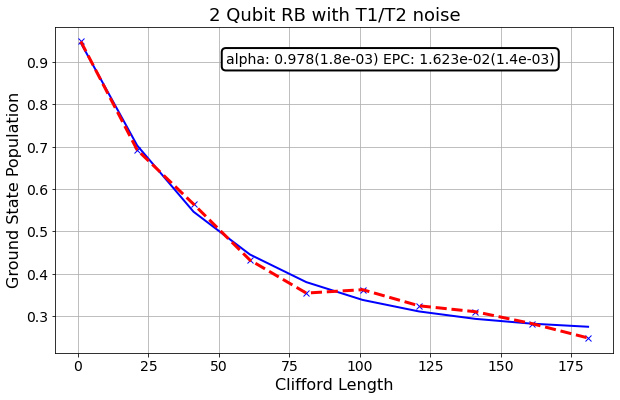

In [16]:
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot the essence by calling RBResult.plot
rb_result_01.plot(ax=ax, add_label=True, show_plt=False)

# Add title and label
ax.set_title('2 Qubit RB with T1/T2 noise', fontsize=18)

plt.show()

We count again the number of **gates per Clifford** as before, and calculate the **two-qubit Clifford gate error**, using the predicted primitive gate errors from the coherence limit.

In [17]:
#Count the number of single and 2Q gates in the 2Q Cliffords
gates_per_cliff = exp01.gates_per_clifford()
for basis_gate in basis_gates:
    print("Number of %s gates per Clifford: %f "%(basis_gate ,
                                                  np.mean([gates_per_cliff[0][basis_gate],
                                                           gates_per_cliff[1][basis_gate]])))

Number of u1 gates per Clifford: 0.127174 
Number of u2 gates per Clifford: 1.601087 
Number of u3 gates per Clifford: 0.213587 
Number of cx gates per Clifford: 1.430435 


In [18]:
# Predicted primitive gate errors from the coherence limit
u2_error = RBUtils.coherence_limit(1,[t1],[t2],gate1Q)
u3_error = RBUtils.coherence_limit(1,[t1],[t2],2*gate1Q)
epg_2q = RBUtils.coherence_limit(2,[t1,t1],[t2,t2],gate2Q)
epgs_1q = {'u1': 0, 'u2': u2_error, 'u3': u3_error}
pred_epc = RBUtils.calculate_2q_epc(
    gate_per_cliff=gates_per_cliff,
    epg_2q=epg_2q,
    qubit_pair=[0, 1],
    list_epgs_1q=[epgs_1q, epgs_1q])

# Calculate the predicted epc
print("Predicted 2Q Error per Clifford: %e"%pred_epc)

Predicted 2Q Error per Clifford: 1.273799e-02


# Interleaved RB

In [19]:
from qiskit.circuit.library import XGate
exp1 = InterleavedRBExperiment(XGate(), nseeds=5, qubits=[1], lengths=[x*3 for x in nCliffs])

c = QuantumCircuit(2)
c.h(0)
c.cx(0,1)
exp02 = InterleavedRBExperiment(c, nseeds=5, qubits=[0,2], lengths=nCliffs)

backend = qiskit.Aer.get_backend('qasm_simulator')
shots = 200

noise_model = NoiseModel()
p1Q = 0.002
p2Q = 0.01

noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')
interleaved_rb_result_1 = exp1.run(backend, noise_model=noise_model, shots=shots)
interleaved_rb_result_02 = exp02.run(backend, noise_model=noise_model, shots=shots)

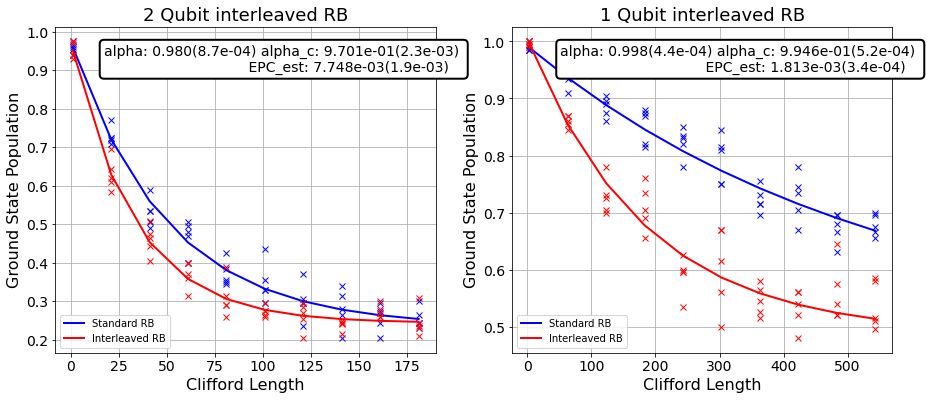

In [20]:
plt.figure(figsize=(15, 6))
results = [interleaved_rb_result_02, interleaved_rb_result_1]
for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    results[i].plot(ax=ax, add_label=True, show_plt=False)
    # Add title and label
    ax.set_title('%d Qubit interleaved RB'%(results[i].num_qubits()), fontsize=18)
    
plt.show()

      ┌───┐┌─────┐┌───┐     ┌───┐┌───┐ ░     ░      ┌───┐┌───┐      ┌───┐      »
qr_0: ┤ X ├┤ SDG ├┤ H ├──■──┤ H ├┤ S ├─░──X──░───■──┤ H ├┤ S ├──■───┤ H ├──────»
      ├───┤└┬───┬┘├───┤┌─┴─┐└───┘└───┘ ░  │  ░ ┌─┴─┐├───┤├───┤┌─┴─┐┌┴───┴┐┌───┐»
qr_1: ┤ Y ├─┤ H ├─┤ S ├┤ X ├───────────░──X──░─┤ X ├┤ H ├┤ S ├┤ X ├┤ SDG ├┤ H ├»
      └───┘ └───┘ └───┘└───┘           ░     ░ └───┘└───┘└───┘└───┘└─────┘└───┘»
cr: 2/═════════════════════════════════════════════════════════════════════════»
                                                                               »
«      ┌─┐               
«qr_0: ┤M├───────────────
«      └╥┘┌─────┐┌───┐┌─┐
«qr_1: ─╫─┤ SDG ├┤ Z ├┤M├
«       ║ └─────┘└───┘└╥┘
«cr: 2/═╩══════════════╩═
«       0              1 


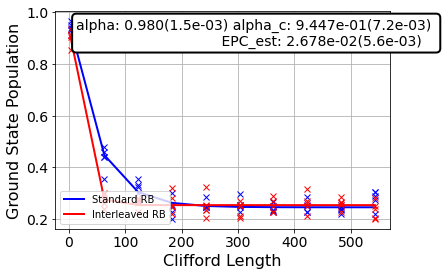

In [21]:
from qiskit.circuit.library import SwapGate
exp1 = InterleavedRBExperiment(SwapGate(), nseeds=5, qubits=[0,1], lengths=[1,2])
print(exp1.generator.circuits()[2])
exp1 = InterleavedRBExperiment(SwapGate(), nseeds=5, qubits=[0,1], lengths=[x*3 for x in nCliffs])
res = exp1.run(backend, noise_model=noise_model, shots=shots)
res.plot()

## CNOT-Dihedral group

In [22]:
exp02 = RBExperiment(nseeds=5, qubits=[0,2], lengths=nCliffs, group_gates='CNOTDihedral')
exp1 = RBExperiment(nseeds=5, qubits=[1], lengths=[x*3 for x in nCliffs], group_gates='CNOTDihedral')
backend = qiskit.Aer.get_backend('qasm_simulator')
shots = 200

rb_result_02 = exp02.run(backend, noise_model=noise_model, shots=shots)
rb_result_1 = exp1.run(backend, noise_model=noise_model, shots=shots)
results = [rb_result_02, rb_result_1]

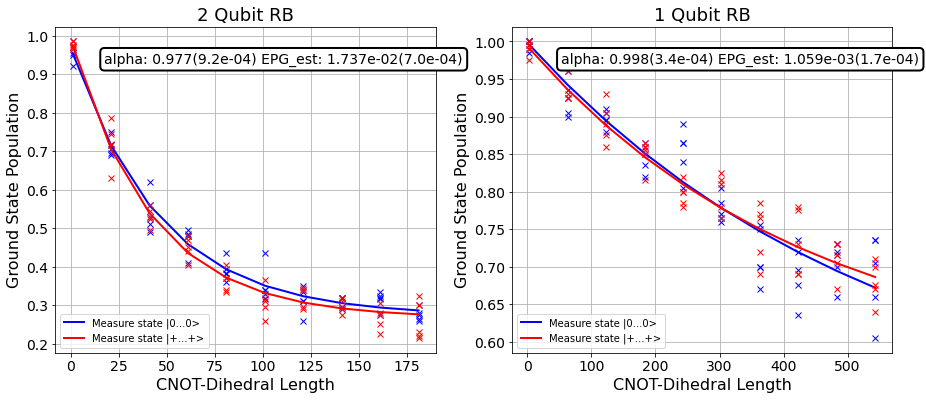

In [23]:
plt.figure(figsize=(15, 6))

for i in range(2):
    ax = plt.subplot(1, 2, i+1)

    # Plot the essence by calling RBResult.plot
    results[i].plot(ax=ax, add_label=True, show_plt=False)

    # Add title and label
    ax.set_title('%d Qubit RB'%(results[i].num_qubits()), fontsize=18)

plt.show()

# Interleaved CNOT-dihedral

In [24]:
c = QuantumCircuit(2)
c.x(0)
c.cx(0,1)
exp1 = InterleavedRBExperiment(XGate(), nseeds=5, qubits=[1], lengths=[x*3 for x in nCliffs], group_gates='CNOTDihedral')
exp02 = InterleavedRBExperiment(c, nseeds=5, qubits=[0,2], lengths=nCliffs, group_gates='CNOTDihedral')

backend = qiskit.Aer.get_backend('qasm_simulator')
shots = 200

noise_model = NoiseModel()
p1Q = 0.002
p2Q = 0.01

noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')
interleaved_rb_result_1 = exp1.run(backend, noise_model=noise_model, shots=shots)
interleaved_rb_result_02 = exp02.run(backend, noise_model=noise_model, shots=shots)

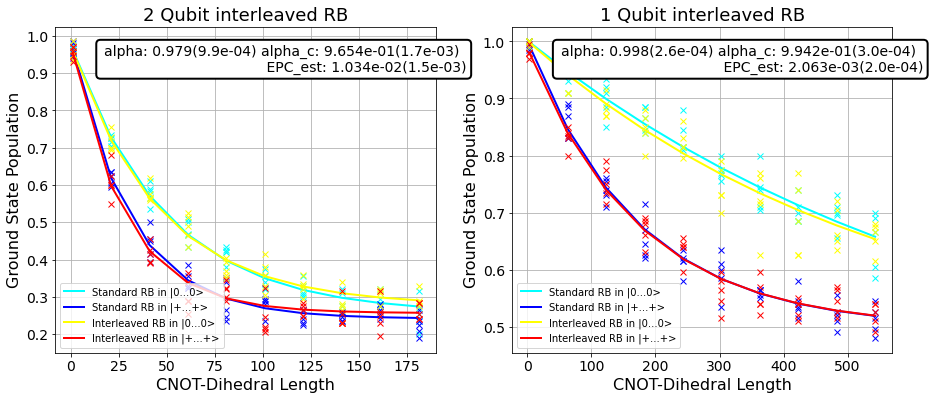

In [25]:
plt.figure(figsize=(15, 6))
results = [interleaved_rb_result_02, interleaved_rb_result_1]
for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    results[i].plot(ax=ax, add_label=True, show_plt=False)
    # Add title and label
    ax.set_title('%d Qubit interleaved RB'%(results[i].num_qubits()), fontsize=18)
    
plt.show()

# Purity RB

In [26]:
noise_model = NoiseModel()
p1Q = 0.002
p2Q = 0.01
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')

exp1 = PurityRBExperiment(nseeds=5, qubits=[1], lengths=[x*3 for x in nCliffs])
exp02 = PurityRBExperiment(nseeds=5, qubits=[0,2], lengths=nCliffs)

exp1_result = exp1.run(backend, noise_model=noise_model, shots=shots)
exp02_result = exp02.run(backend, noise_model=noise_model, shots=shots)

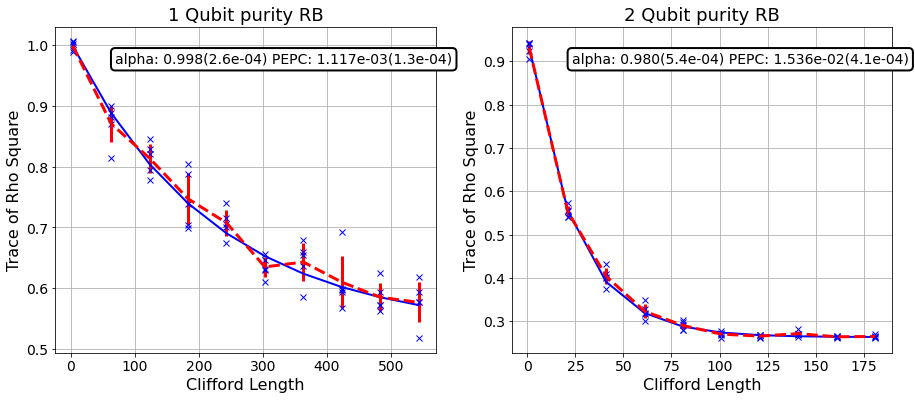

In [27]:
plt.figure(figsize=(15, 6))
results = [exp1_result, exp02_result]
for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    results[i].plot(ax=ax, add_label=True, show_plt=False)
    # Add title and label
    ax.set_title('%d Qubit purity RB'%(results[i].num_qubits()), fontsize=18)
    
plt.show()

## Coherent noise model

In [28]:
err_unitary = np.zeros([2, 2], dtype=complex)
angle_err = 0.1
for i in range(2):
    err_unitary[i, i] = np.cos(angle_err)
    err_unitary[i, (i+1) % 2] = np.sin(angle_err)
err_unitary[0, 1] *= -1.0

error = coherent_unitary_error(err_unitary)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error, 'u3')

In [29]:
exp01 = PurityRBExperiment(nseeds=5, qubits=[0,1], lengths=nCliffs)
exp01_result = exp01.run(backend, noise_model=noise_model, shots=shots)

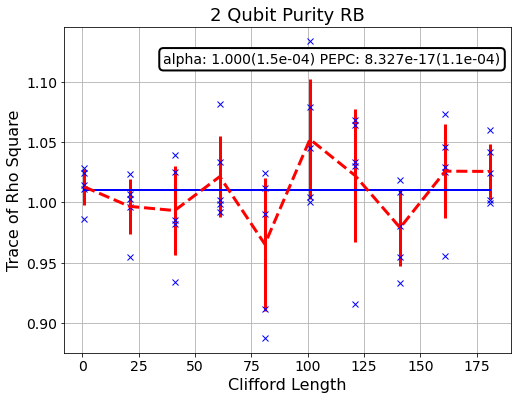

In [30]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
exp01_result.plot(ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('2 Qubit Purity RB', fontsize=18)

plt.show()

In [31]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright